In [4]:
using Pkg
Pkg.activate(@__DIR__)

  Activating environment at `~/Julia/doc/cscs_gpu_course/Project.toml`


# Programming models

There are different ways of programming (NVIDIA) GPUs in Julia, at different levels of abstraction.

## Array programming

The easiest way to use a GPU is via vectorized array operations. Each of these operations will be backed by one or more GPU kernels, so as long as your data is large enough you'll get to see some nice speed-ups. For NVIDIA GPUs, you use the `CuArray` type from CUDA.jl:

In [1]:
using CUDA
CuArray([1])

1-element CuArray{Int64, 1, CUDA.Mem.DeviceBuffer}:
 1

A `CuArray` is an object that can be used on the CPU, representing a chunk of memory on the GPU. This is important: All operations on a `CuArray` are CPU methods which launch on or more GPU kernels operating on the values in GPU memory. This has several consequences.

### Scalar iteration is slow

Because `CuArray` operations start on the CPU, the array operations should be relatively heavyweight to offset the overhead it takes to launch one or more GPU operations. That means that a scalar `for` loop processing one element at a time is very wasteful:

In [2]:
A = CuArray(1:10)
A_sum = zero(eltype(A))
for I in eachindex(A)
    A_sum += A[I]
end
A_sum

┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007fc5b0941510.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArrays /home/tim/Julia/depot/packages/GPUArrays/3sW6s/src/host/indexing.jl:56


55

Because of this kind of programming pattern, iterating the array and fetching one scalar at a time (hence 'scalar iteration'), being so slow CUDA.jl warns about it. With the above snippet, the situation is actually even worse: Not only does every iteration require a GPU operation to fetch an element, the `getindex` call is also the only array operation meaning that the actual summation won't even run on the GPU!

The solution here is to use the `sum` function that performs the entire operation as a single step. More on these operations later.
To disallow scalar iteration, use the `allowscalar` function:

In [3]:
CUDA.allowscalar(false)
A[1]

LoadError: Scalar indexing is disallowed.
Invocation of getindex resulted in scalar indexing of a GPU array.
This is typically caused by calling an iterating implementation of a method.
Such implementations *do not* execute on the GPU, but very slowly on the CPU,
and therefore are only permitted from the REPL for prototyping purposes.
If you did intend to index this array, annotate the caller with @allowscalar.

### CuArray isn't device-compatible

A more subtle result of `CuArray` being the CPU-side object is that these objects cannot be used directly on the GPU. Instead, a conversion to `CuDeviceArray` happens:

In [4]:
@device_code_warntype @cuda (A->nothing)(A)

PTX CompilerJob of kernel #2(CuDeviceVector{Int64, 1}) for sm_75

Variables
  #self#::Core.Const(var"#2#3"())
  A::CuDeviceVector{Int64, 1}

Body::Nothing
1 ─     return Main.nothing


Typically, this conversion is hidden and shouldn't affect you as an end user. The only time you need to take care, is when embedding `CuArray`s in a structure:

In [5]:
struct MyStruct
    inner::CuArray
end
B = MyStruct(A)
@cuda (A->nothing)(B)

LoadError: GPU compilation of kernel #4(MyStruct) failed
KernelError: passing and using non-bitstype argument

Argument 2 to your kernel function is of type MyStruct, which is not isbits:
  .inner is of type CuArray which is not isbits.
    .storage is of type Union{Nothing, CUDA.ArrayStorage{B}} where B which is not isbits.
    .dims is of type Tuple{Vararg{Int64, N}} where N which is not isbits.



Here, CUDA.jl makes it clear that a `CuArray` isn't GPU compatible because it's not an `isbits` type. The underlying reason is that the automatic conversion from `CuArray` to `CuDeviceArray` doesn't know about your `MyStruct` and how to convert it to something GPU-compatible. This conversion is done using Adapt.jl, and to make this code work you need to teach Adapt about how to convert `MyStruct` objects:

In [6]:
# to store both a CuArray and a CuDeviceArray
# our struct needs to be parametric
struct MyParametricStruct{T<:AbstractArray}
    inner::T
end

using Adapt
Adapt.adapt_structure(to, x::MyParametricStruct) = MyParametricStruct(adapt(to, x.inner))

C = MyParametricStruct(A)
@device_code_warntype @cuda (A->nothing)(C)

PTX CompilerJob of kernel #6(MyParametricStruct{CuDeviceVector{Int64, 1}}) for sm_75

Variables
  #self#::Core.Const(var"#6#7"())
  A::MyParametricStruct{CuDeviceVector{Int64, 1}}

Body::Nothing
1 ─     return Main.nothing


### Array operations

Many array operations from Julia's standard library and package ecosystem Just Work, because they rely on the `AbstractArray` interfaces that are implemented by `CuArray`. Still, CUDA.jl specializes a bunch of methods for several reasons:

- compatibility: to avoid scalar iteration, or calling into a C library with CPU code (e.g. BLAS, LAPACK, ...)
- performance: by using GPU-optimized implementations, either implemented in Julia or in vendor libraries

If an array operation isn't available, two kinds of errors might occur:

- scalar iteration: when the default implementation processes individual elements at a time
- invalid conversions to a CPU pointer

In [7]:
ccall(:whatever, Nothing, (Ptr{Float32},), A)

LoadError: ArgumentError: cannot take the CPU address of a CuArray{Int64, 1, CUDA.Mem.DeviceBuffer}

In that case, either you need to use different (supported) array operations, or fix the implementation in CUDA.jl. Such a fix can mean using functions from a CUDA library, using existing operations, or writing your own kernel.

### Exercise: Matrix RMSE

As an trivial exercise, try to compute the RMSE of two matrices on the GPU:

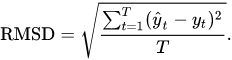

In [8]:
A = rand(1024, 1024)
B = rand(1024, 1024)
sqrt(sum((A-B).^2) / length(A))

0.4083871458683567

Easy enough, just changing the type of the input arrays to `CuArray` and the computation of C just works:

In [9]:
A = CuArray(A)
B = CuArray(B)
sqrt(sum((A-B).^2) / length(A))

0.4083871458683567

This is of course a trivial example, but let's keep it simple for now. The next notebooks will start from this example and create something realistic out of it.

## Kernel programming

Kernels are scalar functions that get executed multiple times in parallel. Each 'thread' runs on one of the many streaming multiprocessors a GPU has, and threads running on a single SM are called a 'block'. Within a SM, some threads are always executed together; these form a 'warp' of 32 threads. Efficient communication between these entities is required to effectively use the GPU:

- between blocks: global memory
- within a block: shared memory
- within a warp: via registers (shuffle)

### Hardware indices

You can fetch the thread, block and warp index using specific functions that query hardware indices:

- `threadIdx()` and `blockDim()`: 3D
- `blockIdx()` and `gridDim()`: 3D
- `laneid()` and `warpsize()`

When you don't need to care about which block a thread is part of, a very common index calculation is as follows:

In [10]:
function kernel()
    i = (blockIdx().x-1) * blockDim().x + threadIdx().x
    @cushow i
    return
end
@cuda threads=2 blocks=2 kernel()

CUDA.HostKernel{typeof(kernel), Tuple{}}(kernel, CuContext(0x00000000062264a0, instance f02fca961a36c4ad), CuModule(Ptr{Nothing} @0x0000000009d56840, CuContext(0x00000000062264a0, instance f02fca961a36c4ad)), CuFunction(Ptr{Nothing} @0x00000000094ce9c0, CuModule(Ptr{Nothing} @0x0000000009d56840, CuContext(0x00000000062264a0, instance f02fca961a36c4ad))), CUDA.KernelState(Ptr{Nothing} @0x00007fc560c00000))

i = 1
i = 2
i = 3
i = 4


### Synchronization

If threads are working together -- say, they are using the same global memory, or are communicating using shared memory or finer-grained intrinsics -- you may want to have threads on each other. Note that this is only possible **within a block**; different blocks generally cannot wait on one another.

Let's look at a contrived example:

In [11]:
A = CUDA.zeros(512)

function kernel(A)
    # simple kernel without multiple blocks
    i = threadIdx().x
    
    # first thread sets up the data
    if i == 1
        A[1] = 42
    end
    
    sync_threads()
    
    # other threads can now read this data
    if i != 1
        A[i] = A[1]
    end
    
    return
end
@cuda threads=length(A) kernel(A)
unique(Array(A))

1-element Vector{Float32}:
 42.0

Note how we didn't put `sync_threads()` inside of the branch; All threads need to reach the synchronization point for the kernel to make progress. This makes it dangerous to synchronize from a branch, as the branch cannot be divergent within a block or the kernel would deadlock!

When coordinating within the warp, you may need the `sync_warp()` function. A detailed explanation of warp-level programming is out of scope for this notebook, refer to the [NVIDIA developer blog](https://developer.nvidia.com/blog/using-cuda-warp-level-primitives/) for more information.

### Atomic operations

When you want to use the same global memory from different threads, you may want to use atomic operations. For example:

In [12]:
A_sum = CUDA.zeros(1)
A = CUDA.rand(512)

function kernel(A, A_sum)
    i = threadIdx().x
    CUDA.@atomic A_sum[] += A[i]
    return
end
@cuda threads=length(A) kernel(A, A_sum)
Array(A_sum)[]

255.92522f0

You shouldn't overuse atomics though, as they generally serialize execution and thus are very expensive! But they may be useful for an initial implementation (i.e. before considering more fine-grained communication), or to reduce values from different blocks (because of the difficulty of synchronizing the grid).

### Output

To help with implementing a kernel, there's a couple of helpful macros to generate output:

In [13]:
function kernel()
    i = threadIdx().x
    @cuprintf "I'm thread %ld\n" Int(i)
    return
end
@cuda kernel();

However, `@cuprintf` is a bit cumbersome, so we have `@cuprintln` trying to automatically generate an appropriate formatting string, while even supporting string interpolation:

In [14]:
function kernel()
    i = threadIdx().x
    @cuprintln "I'm thread $i"
    return
end
@cuda kernel();

I'm thread 1


And for quick debugging, we have a helpful `@cushow` you can surround expressions with:

In [15]:
function kernel()
    i = @cushow(threadIdx().x)
    return
end
@cuda kernel();

I'm thread 1


### Exercise: Matrix RMSE kernel

We now have all the pieces needed to port our RMSE calculation to a kernel.

In [16]:
A = CUDA.rand(10,10)
B = CUDA.rand(10,10)
sqrt(sum((A-B).^2)/length(A))

(threadIdx()).x = 1


0.41447648f0

Try to write a kernel that takes a single-item output array as an argument:

In [17]:
C = CUDA.similar(A, 1)

function rmse_kernel(C, A, B)
    # ...
    return
end

@cuda threads=length(A) rmse_kernel(C, A, B)
C

1-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 0.0

In [18]:
function rmse_kernel(C, A, B)  
    i = threadIdx().x

    # initialize the memory
    if i == 1
        C[] = 0
    end
    sync_threads()
    
    # process an element on each thread
    a = A[i]
    b = B[i]
    CUDA.@atomic C[] += (a-b)^2
    sync_threads()
    
    # finalize the computation
    if i == 1
        C[1] = sqrt(C[] / length(A))
    end
    return
end

@cuda threads=length(A) rmse_kernel(C, A, B)
C

1-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 0.4144765

## High-level kernel programming

There's a couple of packages that aim to simplify kernel programming without resorting to array operations (which may result in extraneous kernel launches, more on that in some of the next notebooks).

### Tullio.jl

With Tullio, it's easy to write kernels using index notation. This makes it easy to express operations like our RMSE calculation in a single expression which typically will also be compiled to a single kernel:

In [4]:
using Tullio

A = ones(10, 10)

# assigning with `:=` creates a new array
@tullio C[i,j] := A[i,j]

10×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [5]:
# dropping an index will sum across that dimension
@tullio C[i] := A[i,j]

10-element Vector{Float64}:
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0

In [10]:
# pipe operators can be used to apply functions 'outside' of the reduction
@tullio C[] := A[i,j] |> log10(_)

0-dimensional Array{Float64, 0}:
2.0

#### Exercise: Matrix RMSE with index notation

With these bits, try to create an index notation expression that computes the RMSE of two matrices.

In [11]:
using Tullio

A = rand(1024, 1024)
B = rand(1024, 1024)
sqrt(sum((A-B).^2)/length(A))

0.4080676291810436

In [12]:
@tullio C[] := (A[i,j] - B[i,j])^2 |> sqrt(_ / length(A))

0-dimensional Array{Float64, 0}:
0.4080676291810391

To use Tullio with GPU arrays, you need to install and import the relevant CUDA support packages:

In [20]:
using CUDA, CUDAKernels, KernelAbstractions

In [21]:
A = CUDA.rand(1024, 1024)
B = CUDA.rand(1024, 1024)
@tullio C[] := (A[i,j] - B[i,j])^2 |> sqrt(_ / length(A))

0-dimensional CuArray{Float32, 0, CUDA.Mem.DeviceBuffer}:
0.4084926

Tullio is great for quickly creating portable kernels (CPU, different GPU back-ends) for mathematical operations, and it can be seen as a generalization of broadcast.

### KernelAbstractions.jl

For a more flexible API, i.e. not restricted to Tullio's index notation, but still retaining Tullio's portability, you can consider the KernelAbstractions.jl framework that Tullio.jl is built on:

In [22]:
using KernelAbstractions

In [23]:
@kernel function ka_kernel(A)
    # simple kernel without multiple blocks
    i = @index(Global, Linear)
    
    # first thread sets up the data
    if i == 1
        A[1] = 42
    end
    
    @synchronize()
    
    # other threads can now read this data
    if i != 1
        A[i] = A[1]
    end
end;

In [24]:
A = zeros(512)

the_ka_kernel = ka_kernel(CPU(), 16)
event = the_ka_kernel(A, ndrange=size(A))
wait(event)
unique(A)

2-element Vector{Float64}:
 42.0
  0.0

The programming interface is now much closer to CUDA.jl's, while retaining platform portability!

In [25]:
using CUDA, CUDAKernels

In [26]:
A = CUDA.zeros(512)
the_ka_kernel = ka_kernel(CUDADevice(), 16)
event = the_ka_kernel(A, ndrange=size(A))
wait(event)
unique(Array(A))

1-element Vector{Float32}:
 42.0

The disadvantage of platform portability of course is that KernelAbstraction.jl's feature set is limited to the common denominator of all supported platforms. That means many CUDA features, like atomics or warp-level programming, are not supported. In addition, KernelAbstractions is built on Cassette.jl which will incur a significant compilation cost for nontrivial applications.